## Cat Dog Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

You can obtain the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

This case study is adopted from https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Import Library

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
mypath='drive/MyDrive/Courses/MagniMind/Mentorship Program/DL-MentorProgram/DL_Mentor_Week2/Class 2/Week2-Class2-St/input_small'
print(os.listdir(mypath))
#print(os.listdir("../input"))

['train_small', 'test1_small']


In [ ]:
print(os.path.join(mypath, 'train_small'))

drive/MyDrive/Courses/MagniMind/Mentorship Program/DL-MentorProgram/DL_Mentor_Week2/Class 2/Week2-Class2-St/input_small/train_small


### 2. Define Constants

In [ ]:
FAST_RUN = True #False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### 3. Prepare Training Data

In [ ]:
filenames = os.listdir(os.path.join(mypath, 'train_small'))
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [ ]:
df.tail()

,filename,category
2496,cat.12086.jpg,0
2497,dog.4606.jpg,1
2498,cat.6735.jpg,0
2499,cat.5266.jpg,0
2500,dog.5078.jpg,1


#### See Total In count

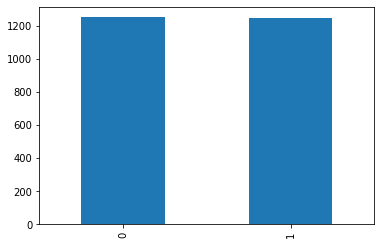

In [ ]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

#### See sample image

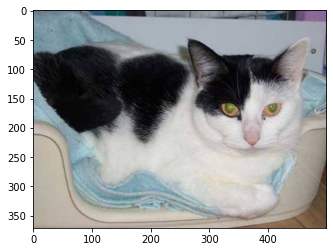

In [ ]:
sample = random.choice(filenames)
pathimage=os.path.join(mypath, 'train_small/')
image = load_img(pathimage+sample)
plt.imshow(image)

### 4. Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single dimension array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer reduces the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

NameError: ignored

### 5. Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

Keras supports the early stopping of training via a callback called EarlyStopping.

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

The `EarlyStopping` callback is configured when instantiated via arguments.

The `monitor` allows you to specify the performance measure to monitor in order to end training.

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

### 6. Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

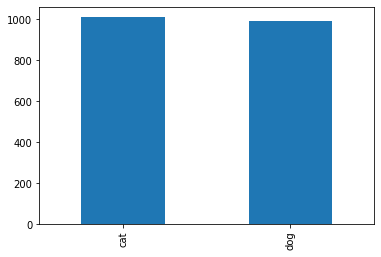

In [ ]:
train_df['category'].value_counts().plot.bar()

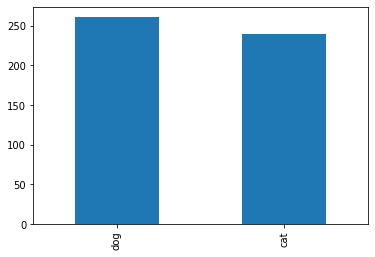

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

### 7. Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    pathimage, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    pathimage, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 501 validated image filenames belonging to 2 classes.


### 8. See how our generator work

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    pathimage, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


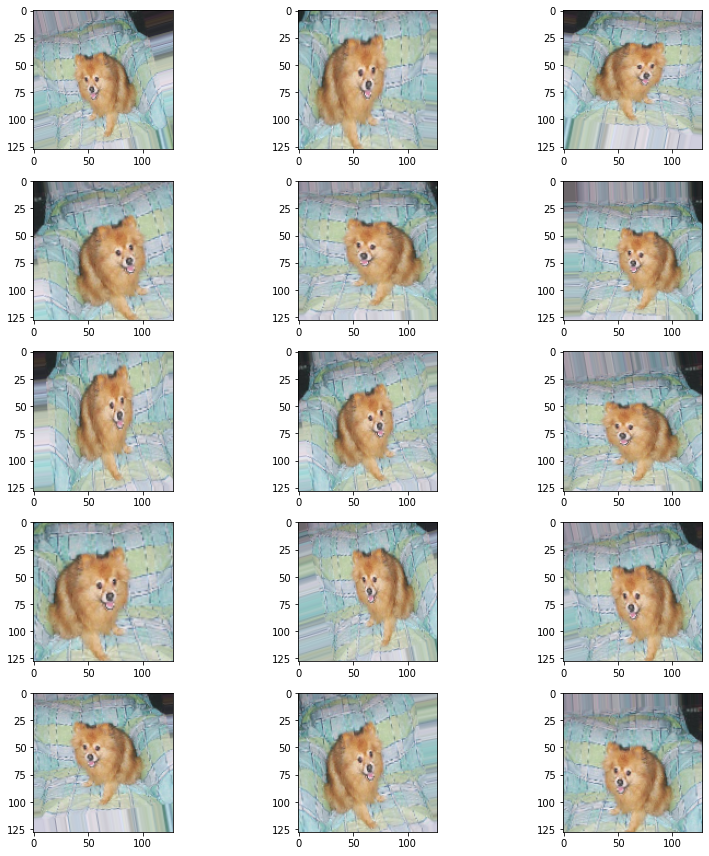

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

### 9. Fit Model

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 659s 7s/step - loss: 1.3134 - accuracy: 0.5575 - val_loss: 0.6773 - val_accuracy: 0.5820
Epoch 2/3
100/100 [==============================] - 125s 1s/step - loss: 0.9471 - accuracy: 0.5875 - val_loss: 0.9330 - val_accuracy: 0.4880
Epoch 3/3
100/100 [==============================] - 120s 1s/step - loss: 0.7828 - accuracy: 0.6230 - val_loss: 1.1316 - val_accuracy: 0.4800

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


### 10. Save Model

In [ ]:
model.save_weights("model.h5")

### 11. Virtualize Training

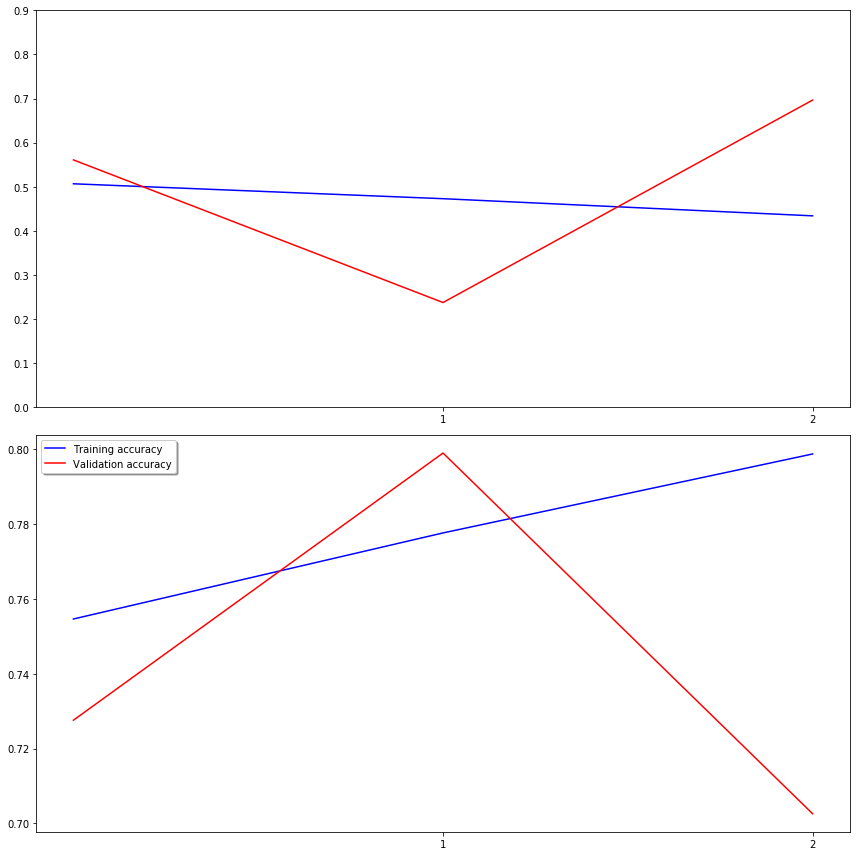

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### 12. Prepare Testing Data

In [ ]:
testpath=os.path.join(mypath, 'test1_small')
test_filenames = os.listdir(testpath)
test_df = pd.DataFrame({
    'filename': test_filenames
})
test_df = pd.DataFrame([ x  for x in test_df['filename'] if x.split('.')[1]=='jpg'])
test_df.columns=['filename']
nb_samples = test_df.shape[0]
test_df[:1]


,filename
0,244.jpg


In [ ]:
nb_samples

1251

### 13. Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    testpath, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,
    #validate_filenames=False
)

Found 1251 non-validated image filenames.


### 14. Predict

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
predict.shape

(1251, 2)

In [ ]:
test_df.shape

(1251, 1)

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

#### Virtualize Result

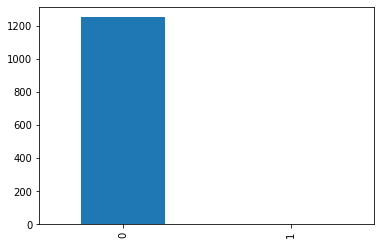

In [ ]:
test_df['category'].value_counts().plot.bar()

### 15. See predicted result with images

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(testpath+'/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.